# Skin Cancer Classification: Malignant vs. Benign

## Introduction

This project aims to classify images of skin moles as benign or malignant using a deep learning approach. We were motivated to work on this project due to its potential real-world impact, as skin cancer is a prevalent health concern. Our final goal is to develop a model that accurately classifies skin cancer images and provides users with an accuracy probability metric that they can share with their healthcare providers.

## Dataset

The dataset includes 660 samples covering benign (360) and malignant (300) skin moles. We may augment (flip, change colors, add noise, etc.) the images and pass them back through in a separate epoch.

## Literature Review

We reviewed relevant research papers to inform our approach:

**1. A robust deep learning framework for multiclass skin cancer classification** by Burhanettin Ozdemir & Ishak Pacal: This paper proposes a hybrid deep learning model combining ConvNeXtV2 blocks and separable self-attention mechanisms for accurate multiclass skin lesion classification. We believe this approach could be adapted to our task of classifying benign and malignant moles.

**2. Skin Cancer Detection Using Deep Learning—A Review:** This review paper focuses on the challenges and advancements in skin cancer classification using deep learning. It provides a comprehensive overview of CNN architectures like VGG, ResNet, DenseNet, and MobileNet, reporting accuracies up to 99.36% and F1-scores as high as 0.97. DenseNet, Xception, and ensemble methods are highlighted as top performers, which we will consider for our project.

## Existing Methods

We plan to start with Convolutional Neural Networks (CNNs) as our baseline model. Specifically, we will test architectures like ResNet50 due to its proven success in prior research and in-class exercises. If the initial results are not satisfactory, we will explore the methods and models mentioned in the literature review, such as DenseNet, Xception, and ensemble methods.

## Novelty

Our project distinguishes itself from prior work in several ways:

1. **Binary Classification Focus:** While many studies focus on multiclass classification of various lesion types, we specifically target the binary classification of malignant vs. benign moles, allowing for optimization tailored to this task.

2. **Data Augmentation and Transfer Learning:** We will combine data augmentation techniques with transfer learning using pre-trained models like DenseNet or Xception, fine-tuning them on our dataset for improved performance.

3. **Confidence Probability Output:** We aim to provide a confidence probability for each prediction, enhancing user understanding of model certainty. This feature is not emphasized in the reviewed studies and adds value to our project's practical application.

## Experiment Plan

1. **Dataset Split:**
   - We will divide the dataset into 70% for training, 15% for validation, and 15% for testing. This will allow us to train the model, tune hyperparameters on a separate validation set, and evaluate the final performance on an unseen test set.
   



Mounted at /content/drive


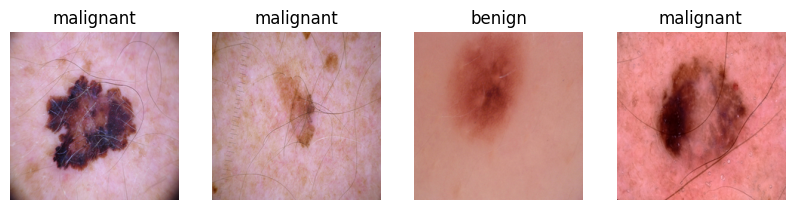

In [ ]:
# Cell 1: Data Preparation
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Dataset path
dataset_path = '/content/drive/MyDrive/AIFinal'  # Update with your dataset path

# Function to get all image paths and labels
def get_image_paths_and_labels(data_dir):
    images = []
    labels = []
    class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                images.append(os.path.join(class_dir, img_name))
                labels.append(class_to_idx[class_name])

    return images, labels, class_names, class_to_idx

# Get training and testing data
train_images, train_labels, class_names, class_to_idx = get_image_paths_and_labels(os.path.join(dataset_path, 'train'))
test_images, test_labels, _, _ = get_image_paths_and_labels(os.path.join(dataset_path, 'test'))

# Data Visualization
def visualize_data(dataset_path, num_samples=4):
    class_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    fig, axes = plt.subplots(1, num_samples, figsize=(10, 3))
    for i in range(num_samples):
        class_idx = np.random.randint(len(class_names))
        class_name = class_names[class_idx]
        img_path = os.path.join(dataset_path, class_name, np.random.choice(os.listdir(os.path.join(dataset_path, class_name))))
        image = Image.open(img_path)
        axes[i].imshow(image)
        axes[i].set_title(class_name)
        axes[i].axis('off')
    plt.show()

visualize_data(os.path.join(dataset_path, 'train'))

# Data Preprocessing and Loading
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = CustomDataset(train_images, train_labels, transform=data_transform)
test_dataset = CustomDataset(test_images, test_labels, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Cell 3: Existing Model (ResNet50)
"""
## Existing Model: ResNet50

### Algorithm Explanation

ResNet50 is a 50-layer deep residual network that utilizes residual blocks to address the vanishing gradient problem. These blocks introduce skip connections that allow gradients to flow more easily during backpropagation, enabling the training of very deep networks. We leverage a pre-trained ResNet50 model and fine-tune it on our dataset for skin cancer classification.
"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = models.resnet50(pretrained=True)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(class_names))
model_resnet = model_resnet.to(device)

criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model_resnet.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer_resnet.zero_grad()
        outputs = model_resnet(images)
        loss = criterion_resnet(outputs, labels)
        loss.backward()
        optimizer_resnet.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("ResNet50 training complete.")

model_resnet.eval()
all_predictions_resnet = []
all_labels_resnet = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating ResNet50"):
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions_resnet.extend(predicted.cpu().numpy())
        all_labels_resnet.extend(labels.cpu().numpy())

report_resnet = classification_report(all_labels_resnet, all_predictions_resnet, target_names=class_names)
print("ResNet50 Classification Report:")
print(report_resnet)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 83/83 [00:42<00:00,  1.94it/s]


Epoch 1/10, Loss: 0.4640


Epoch 2/10: 100%|██████████| 83/83 [00:38<00:00,  2.18it/s]


Epoch 2/10, Loss: 0.3915


Epoch 3/10: 100%|██████████| 83/83 [00:39<00:00,  2.13it/s]


Epoch 3/10, Loss: 0.3953


Epoch 4/10: 100%|██████████| 83/83 [00:38<00:00,  2.17it/s]


Epoch 4/10, Loss: 0.3382


Epoch 5/10: 100%|██████████| 83/83 [00:38<00:00,  2.16it/s]


Epoch 5/10, Loss: 0.3267


Epoch 6/10: 100%|██████████| 83/83 [00:38<00:00,  2.17it/s]


Epoch 6/10, Loss: 0.3321


Epoch 7/10: 100%|██████████| 83/83 [00:40<00:00,  2.03it/s]


Epoch 7/10, Loss: 0.3206


Epoch 8/10: 100%|██████████| 83/83 [00:38<00:00,  2.16it/s]


Epoch 8/10, Loss: 0.2976


Epoch 9/10: 100%|██████████| 83/83 [00:38<00:00,  2.17it/s]


Epoch 9/10, Loss: 0.2924


Epoch 10/10: 100%|██████████| 83/83 [00:38<00:00,  2.17it/s]


Epoch 10/10, Loss: 0.2818
ResNet50 training complete.


Evaluating ResNet50: 100%|██████████| 21/21 [00:05<00:00,  4.09it/s]

ResNet50 Classification Report:
              precision    recall  f1-score   support

      benign       0.92      0.83      0.88       360
   malignant       0.82      0.92      0.87       300

    accuracy                           0.87       660
   macro avg       0.87      0.88      0.87       660
weighted avg       0.88      0.87      0.87       660



In [ ]:
# Cell 3: Modified Model (DenseNet121)
"""
## Modified Model: DenseNet121

### Algorithm Explanation

DenseNet121 is a 121-layer convolutional neural network that utilizes dense blocks where each layer is connected to every other layer in a feed-forward fashion. This dense connectivity promotes feature reuse and improves the flow of information through the network, potentially leading to better performance.
"""

model_densenet = models.densenet121(pretrained=True)
num_ftrs = model_densenet.classifier.in_features
model_densenet.classifier = nn.Linear(num_ftrs, len(class_names))
model_densenet = model_densenet.to(device)

criterion_densenet = nn.CrossEntropyLoss()
optimizer_densenet = optim.Adam(model_densenet.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model_densenet.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer_densenet.zero_grad()
        outputs = model_densenet(images)
        loss = criterion_densenet(outputs, labels)
        loss.backward()
        optimizer_densenet.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("DenseNet121 training complete.")

model_densenet.eval()
all_predictions_densenet = []
all_labels_densenet = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating DenseNet121"):
        images, labels = images.to(device), labels.to(device)
        outputs = model_densenet(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions_densenet.extend(predicted.cpu().numpy())
        all_labels_densenet.extend(labels.cpu().numpy())

report_densenet = classification_report(all_labels_densenet, all_predictions_densenet, target_names=class_names)
print("DenseNet121 Classification Report:")
print(report_densenet)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 155MB/s]
Epoch 1/10: 100%|██████████| 83/83 [00:41<00:00,  2.00it/s]


Epoch 1/10, Loss: 0.4167


Epoch 2/10: 100%|██████████| 83/83 [00:38<00:00,  2.14it/s]


Epoch 2/10, Loss: 0.3461


Epoch 3/10: 100%|██████████| 83/83 [00:39<00:00,  2.11it/s]


Epoch 3/10, Loss: 0.3365


Epoch 4/10: 100%|██████████| 83/83 [00:39<00:00,  2.12it/s]


Epoch 4/10, Loss: 0.3057


Epoch 5/10: 100%|██████████| 83/83 [00:39<00:00,  2.13it/s]


Epoch 5/10, Loss: 0.2813


Epoch 6/10: 100%|██████████| 83/83 [00:38<00:00,  2.13it/s]


Epoch 6/10, Loss: 0.2768


Epoch 7/10: 100%|██████████| 83/83 [00:38<00:00,  2.14it/s]


Epoch 7/10, Loss: 0.2706


Epoch 8/10: 100%|██████████| 83/83 [00:38<00:00,  2.13it/s]


Epoch 8/10, Loss: 0.2729


Epoch 9/10: 100%|██████████| 83/83 [00:38<00:00,  2.14it/s]


Epoch 9/10, Loss: 0.2616


Epoch 10/10: 100%|██████████| 83/83 [00:38<00:00,  2.14it/s]


Epoch 10/10, Loss: 0.2458
DenseNet121 training complete.


Evaluating DenseNet121: 100%|██████████| 21/21 [00:05<00:00,  4.20it/s]

DenseNet121 Classification Report:
              precision    recall  f1-score   support

      benign       0.89      0.91      0.90       360
   malignant       0.88      0.87      0.88       300

    accuracy                           0.89       660
   macro avg       0.89      0.89      0.89       660
weighted avg       0.89      0.89      0.89       660



In [ ]:
# Cell 5: Ensemble Method
"""
## Ensemble Method: Averaging Predictions

### Algorithm Explanation

This ensemble method combines the predictions of ResNet50 and DenseNet121 by averaging their predicted probabilities for each class. Averaging predictions from multiple models can often improve overall accuracy and reduce overfitting by leveraging the strengths of different models.
"""

# Ensemble Predictions
model_resnet.eval()
model_densenet.eval()
all_predictions_ensemble = []
all_labels_ensemble = []  # Add this line to store true labels

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Ensemble Predicting"):
        images, labels = images.to(device), labels.to(device)
        outputs_resnet = model_resnet(images)
        outputs_densenet = model_densenet(images)

        # Average the predictions (probabilities)
        ensemble_outputs = (outputs_resnet + outputs_densenet) / 2

        _, predicted = torch.max(ensemble_outputs, 1)
        all_predictions_ensemble.extend(predicted.cpu().numpy())
        all_labels_ensemble.extend(labels.cpu().numpy())  # Store true labels

# Evaluation
report_ensemble = classification_report(all_labels_ensemble, all_predictions_ensemble, target_names=class_names)
print("Ensemble Classification Report:")
print(report_ensemble)

Ensemble Predicting: 100%|██████████| 21/21 [00:07<00:00,  2.94it/s]

Ensemble Classification Report:
              precision    recall  f1-score   support

      benign       0.92      0.87      0.89       360
   malignant       0.85      0.91      0.88       300

    accuracy                           0.88       660
   macro avg       0.88      0.89      0.88       660
weighted avg       0.89      0.88      0.89       660



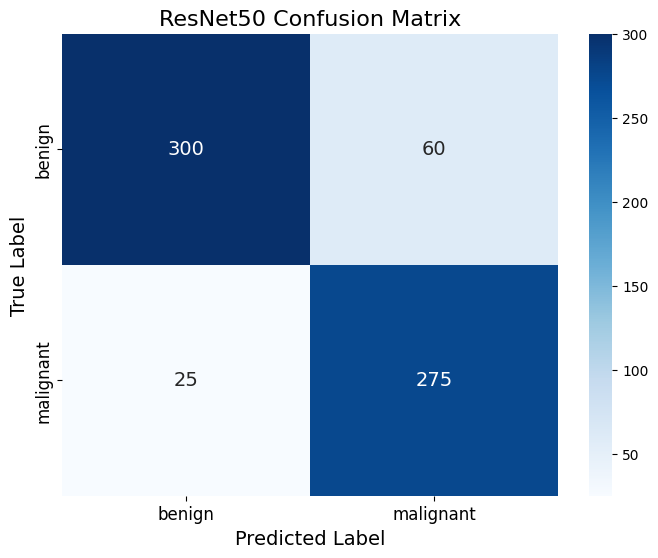

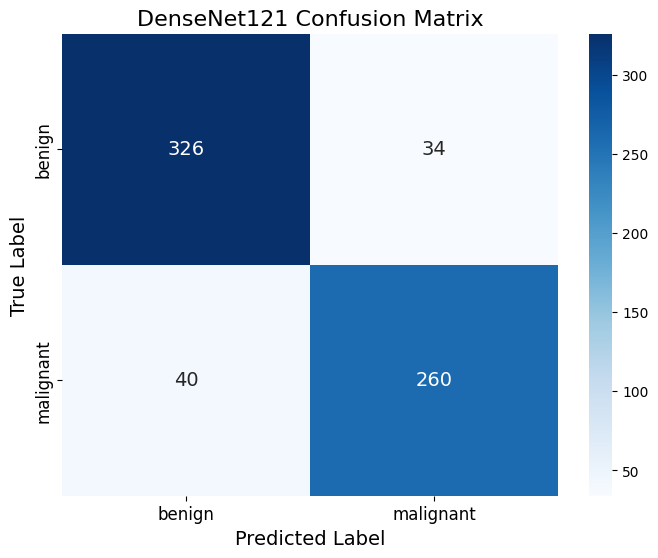

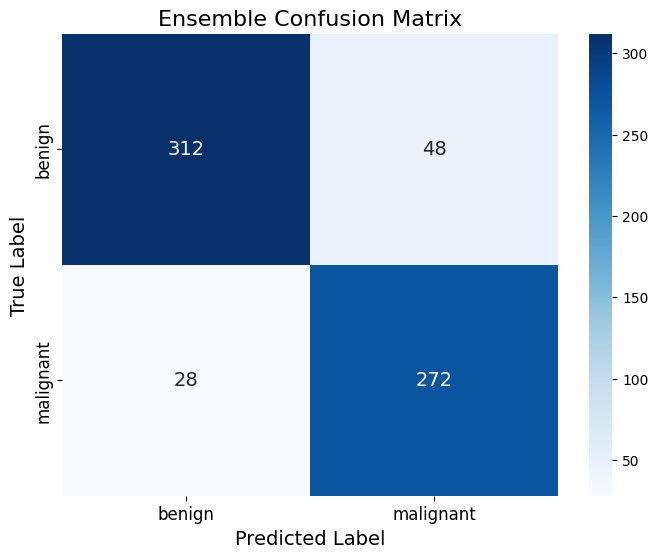

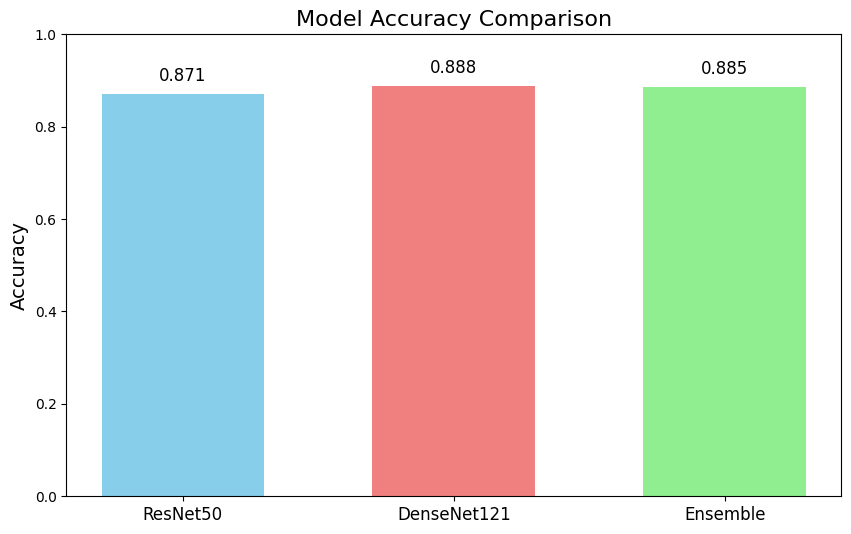

In [ ]:
# Cell 6: Visualization and Analysis
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Function to plot confusion matrix with clearer labels and formatting
def plot_confusion_matrix(y_true, y_pred, model_name):
  """Plots a confusion matrix with clearer labels and formatting."""
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=class_names, yticklabels=class_names,
              annot_kws={"size": 14})  # Increase annotation font size
  plt.title(f"{model_name} Confusion Matrix", fontsize=16)
  plt.xlabel("Predicted Label", fontsize=14)
  plt.ylabel("True Label", fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(all_labels_resnet, all_predictions_resnet, "ResNet50")
plot_confusion_matrix(all_labels_densenet, all_predictions_densenet, "DenseNet121")
plot_confusion_matrix(all_labels_ensemble, all_predictions_ensemble, "Ensemble")

# Function to plot model accuracy comparison with clearer labels and formatting
def plot_accuracy_comparison(accuracies, model_names):
  """Plots a bar chart comparing model accuracies."""
  plt.figure(figsize=(10, 6))
  bars = plt.bar(model_names, accuracies, width=0.6, color=['skyblue', 'lightcoral', 'lightgreen'])
  plt.title('Model Accuracy Comparison', fontsize=16)
  plt.ylabel('Accuracy', fontsize=14)
  plt.ylim([0, 1])
  plt.xticks(fontsize=12)

  # Add accuracy values on top of bars with clearer formatting
  for bar, accuracy in zip(bars, accuracies):
      yval = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02,
               f"{accuracy:.3f}", ha='center', va='bottom', fontsize=12, color='black')

  plt.show()

# Calculate and plot model accuracy comparison
model_accuracies = [
    accuracy_score(all_labels_resnet, all_predictions_resnet),
    accuracy_score(all_labels_densenet, all_predictions_densenet),
    accuracy_score(all_labels_ensemble, all_predictions_ensemble)
]
model_names = ['ResNet50', 'DenseNet121', 'Ensemble']
plot_accuracy_comparison(model_accuracies, model_names)

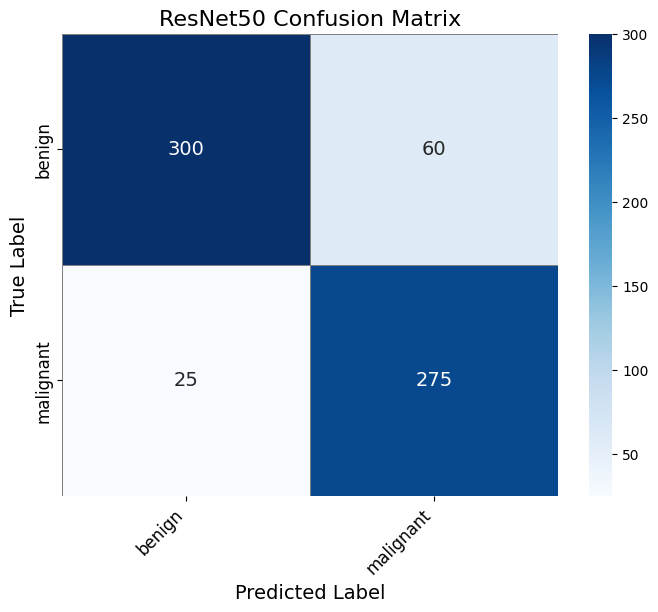

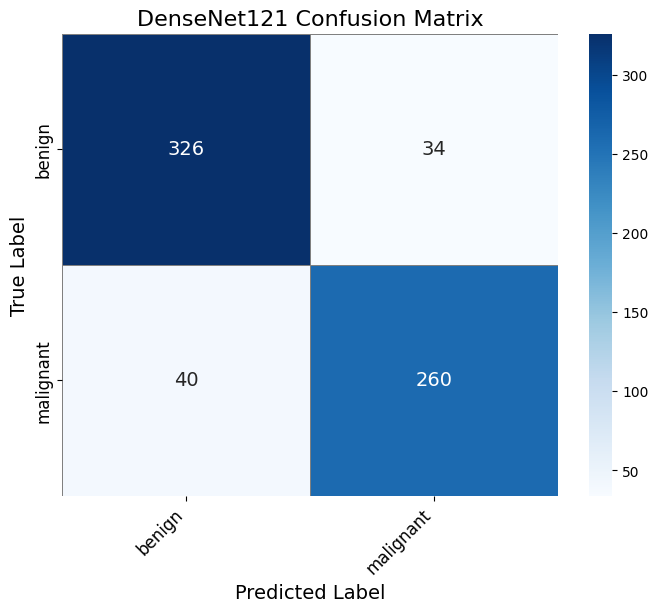

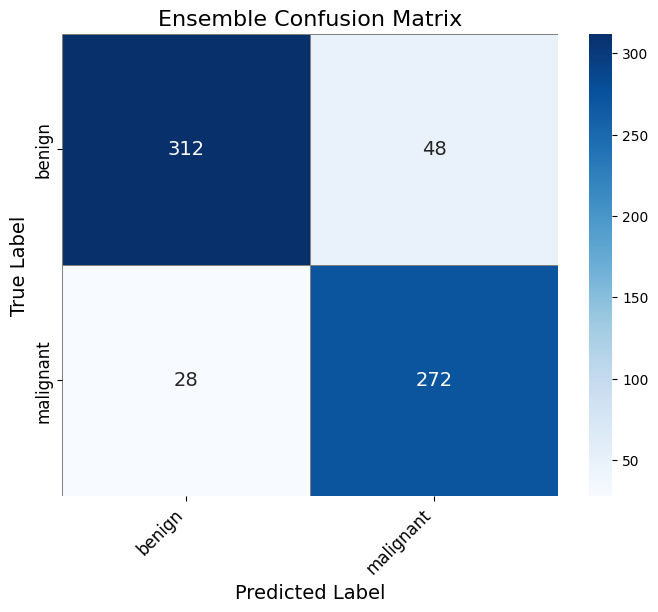

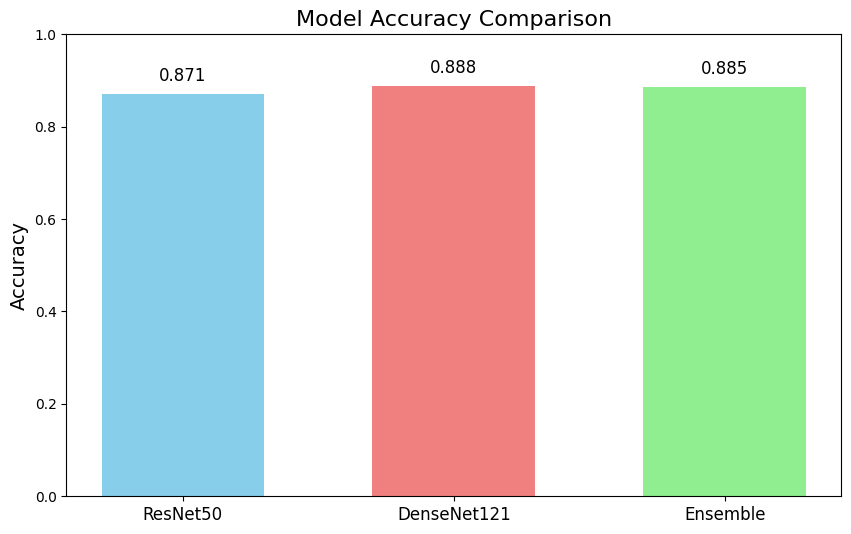

In [ ]:
# Cell 6: Visualization and Analysis
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Function to plot confusion matrix with clearer labels and formatting
def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plots a confusion matrix with clearer labels and formatting."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 14}, linewidths=.5, linecolor="gray")
    plt.title(f"{model_name} Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.xticks(fontsize=12, rotation=45, ha="right")
    plt.yticks(fontsize=12)
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(all_labels_resnet, all_predictions_resnet, "ResNet50")
plot_confusion_matrix(all_labels_densenet, all_predictions_densenet, "DenseNet121")
plot_confusion_matrix(all_labels_ensemble, all_predictions_ensemble, "Ensemble")

# Function to plot model accuracy comparison with clearer labels and formatting
def plot_accuracy_comparison(accuracies, model_names):
    """Plots a bar chart comparing model accuracies."""
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, accuracies, width=0.6, color=['skyblue', 'lightcoral', 'lightgreen'])
    plt.title('Model Accuracy Comparison', fontsize=16)
    plt.ylabel('Accuracy', fontsize=14)
    plt.ylim([0, 1])
    plt.xticks(fontsize=12)

    # Add accuracy values on top of bars with clearer formatting
    for bar, accuracy in zip(bars, accuracies):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02,
                f"{accuracy:.3f}", ha='center', va='bottom', fontsize=12, color='black')

    plt.show()

# Calculate and plot model accuracy comparison
model_accuracies = [
    accuracy_score(all_labels_resnet, all_predictions_resnet),
    accuracy_score(all_labels_densenet, all_predictions_densenet),
    accuracy_score(all_labels_ensemble, all_predictions_ensemble)
]
model_names = ['ResNet50', 'DenseNet121', 'Ensemble']
plot_accuracy_comparison(model_accuracies, model_names)